# ARMA model for Tesla stock price data

### importing all required libraries

In [1]:
import pandas                          as      pd
import numpy                           as      np
import matplotlib.pyplot               as      plt
from   IPython.display                 import  display
from   pylab                           import  rcParams 
from   datetime                        import  datetime, timedelta
from statsmodels.tsa.stattools         import  adfuller
from statsmodels.tsa.stattools         import  pacf
from statsmodels.tsa.stattools         import  acf
from statsmodels.graphics.tsaplots     import  plot_pacf
from statsmodels.graphics.tsaplots     import  plot_acf
from statsmodels.graphics.gofplots     import  qqplot
from statsmodels.tsa.seasonal          import  seasonal_decompose
from statsmodels.tsa.arima_model       import  ARMA
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df=pd.read_csv('Tesla.csv')

In [3]:
df.head()

,Date,Close
0,05-01-2017 16:00,64.57
1,05-02-2017 16:00,63.78
2,05-03-2017 16:00,62.20
3,05-04-2017 16:00,59.09
4,05-05-2017 16:00,61.67


In [211]:
df.tail()

,Date,Close
437,1/25/2019 16:00:00,59.41
438,1/28/2019 16:00:00,59.28
439,1/29/2019 16:00:00,59.49
440,1/30/2019 16:00:00,61.75
441,1/31/2019 16:00:00,61.40


### As stock price data is available for buisness days only, time series might be discontinuos on daily basis. We should update the time series considering business days

In [4]:
from pandas.tseries.offsets import BDay

In [5]:
date = pd.date_range(start='05/01/2017', end='01/31/2019', freq=BDay())

In [6]:
date

DatetimeIndex(['2017-05-01', '2017-05-02', '2017-05-03', '2017-05-04',
               '2017-05-05', '2017-05-08', '2017-05-09', '2017-05-10',
               '2017-05-11', '2017-05-12',
               ...
               '2019-01-18', '2019-01-21', '2019-01-22', '2019-01-23',
               '2019-01-24', '2019-01-25', '2019-01-28', '2019-01-29',
               '2019-01-30', '2019-01-31'],
              dtype='datetime64[ns]', length=459, freq='B')

### adding business dates to time series as a new column

In [7]:
df['TimeStamp']=pd.DataFrame(date,columns=['Date'])

In [8]:
df.shape

(442, 3)

In [9]:
df.head()

,Date,Close,TimeStamp
0,05-01-2017 16:00,64.57,2017-05-01
1,05-02-2017 16:00,63.78,2017-05-02
2,05-03-2017 16:00,62.20,2017-05-03
3,05-04-2017 16:00,59.09,2017-05-04
4,05-05-2017 16:00,61.67,2017-05-05


In [10]:
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])
df_model = df.set_index('TimeStamp')
df_model.head()

,Date,Close
TimeStamp,,
2017-05-01,05-01-2017 16:00,64.57
2017-05-02,05-02-2017 16:00,63.78
2017-05-03,05-03-2017 16:00,62.20
2017-05-04,05-04-2017 16:00,59.09
2017-05-05,05-05-2017 16:00,61.67


In [11]:
df_model=df_model.drop('Date',axis=1)

In [12]:
df_model.head()

,Close
TimeStamp,
2017-05-01,64.57
2017-05-02,63.78
2017-05-03,62.20
2017-05-04,59.09
2017-05-05,61.67


### plotting time series

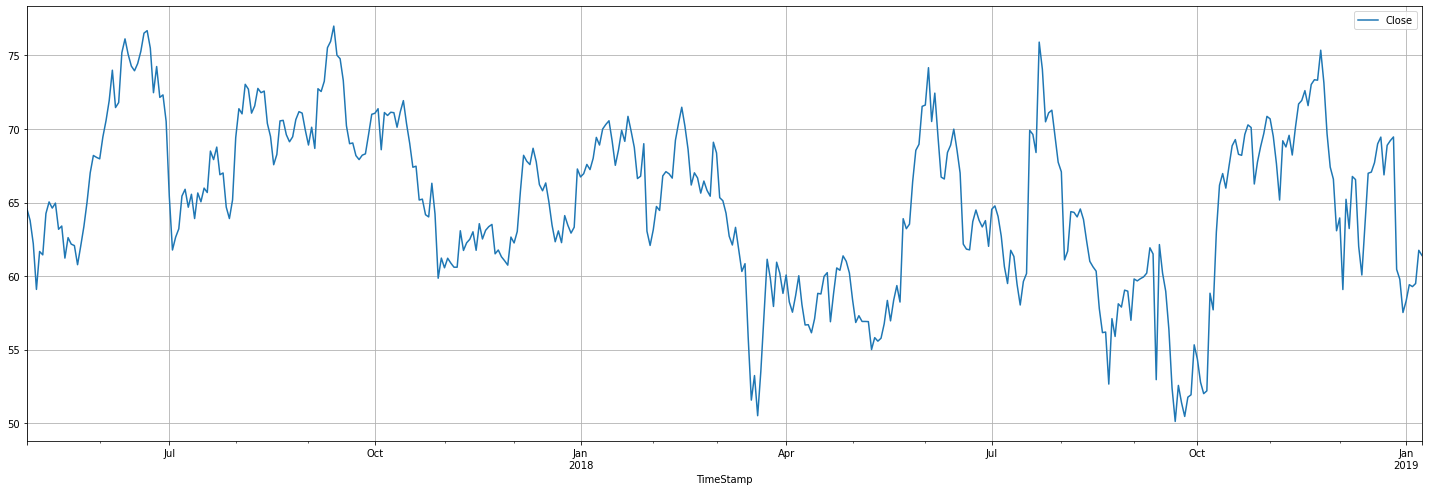

In [13]:
rcParams['figure.figsize'] = 25,8
df_model.plot(grid=True);

In [14]:
df_model.head()

,Close
TimeStamp,
2017-05-01,64.57
2017-05-02,63.78
2017-05-03,62.20
2017-05-04,59.09
2017-05-05,61.67


### cheking for NA values

In [15]:
df_model.isna().value_counts()

Close
False    442
dtype: int64

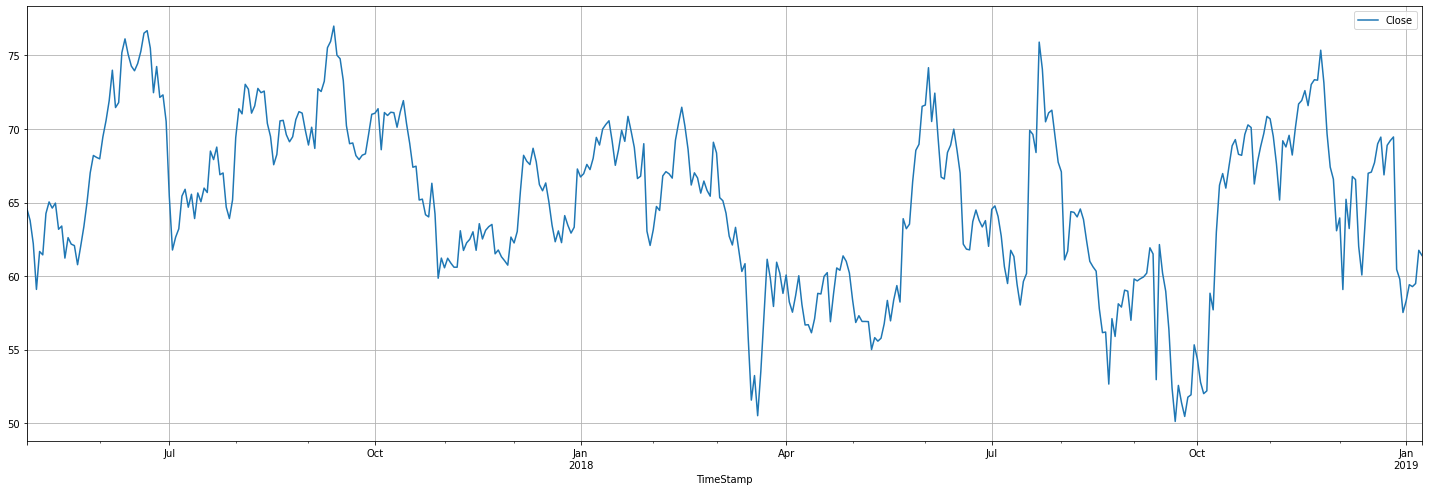

In [16]:
df_model.plot(grid=True);

### lets plot mean across the months to check whether the time series is stationary or not

<AxesSubplot:xlabel='TimeStamp'>

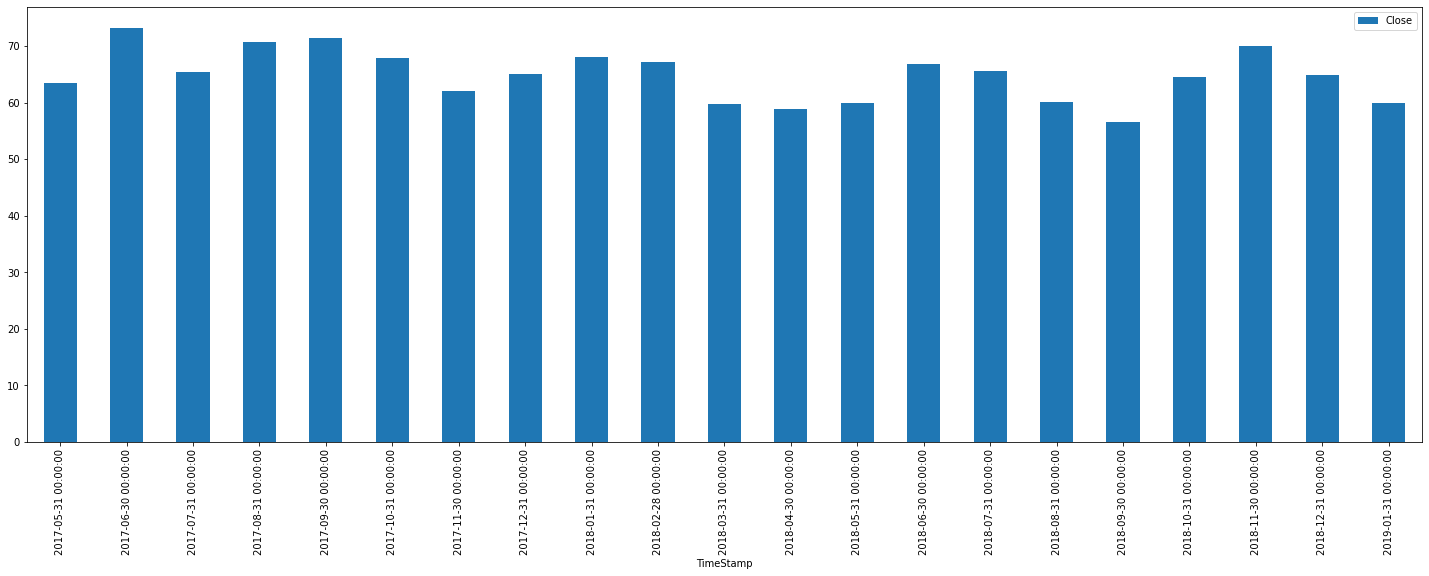

In [18]:
monthly_mean = df_model.resample('M').mean()
monthly_mean.plot.bar()

<AxesSubplot:xlabel='TimeStamp'>

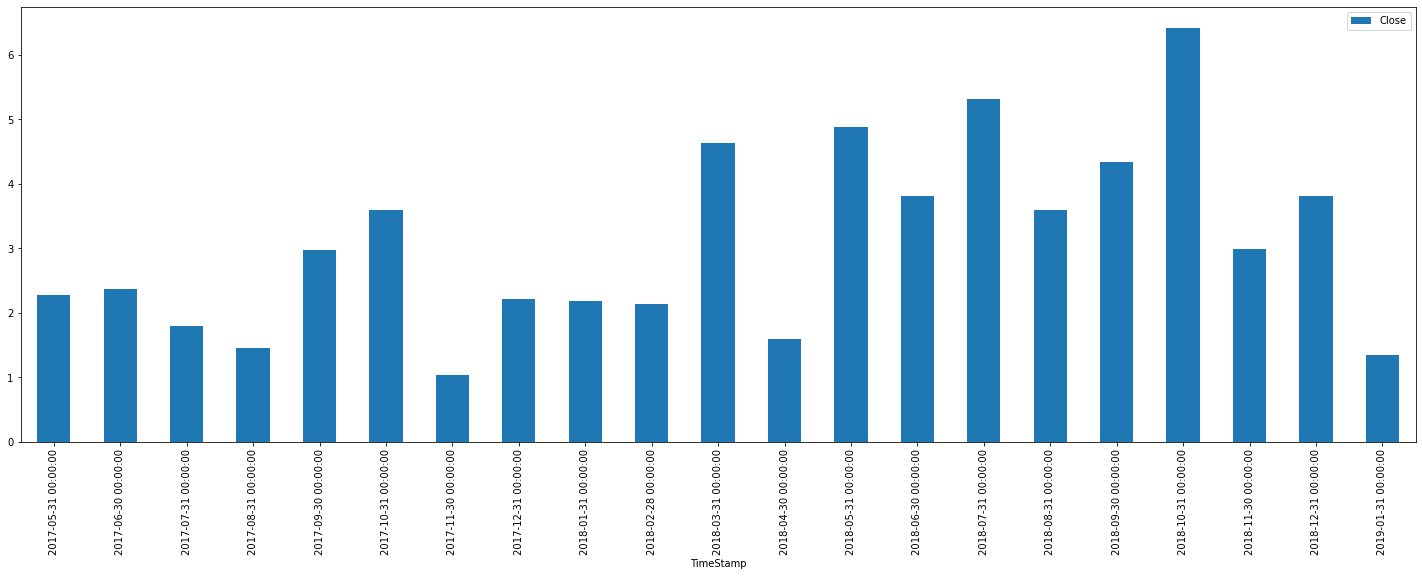

In [20]:
monthly_std = df_model.resample('M').std()
monthly_std.plot.bar()

### It can be observed that there are no as such fluctuations in mean with respect to time

### applying Adfuller test to confirm the same

In [21]:
observations= df_model.values
test_result = adfuller(observations)

In [22]:
test_result

(-3.8371932362652954,
 0.0025488986567834666,
 0,
 441,
 {'1%': -3.4452655826028318,
  '5%': -2.868116205869215,
  '10%': -2.570272878944473},
 1793.1284360926)

In [ ]:
#AT WHAT CONFIDENCE LEVEL YOU CAN REJECT YOUR NULL HYPOTHESIS 0.002<0.01  at 99% I can reject null hypothesis

In [ ]:
#test result<critical value at 99%

In [23]:
print('ADF Statistic: %f' % test_result[0])
print('p-value: %f' % test_result[1])
print('Critical Values:')
for key, value in test_result[4].items():
	print('\t%s: %.5f' % (key, value))

ADF Statistic: -3.837193
p-value: 0.002549
Critical Values:
	1%: -3.44527
	5%: -2.86812
	10%: -2.57027


### test results confirms that the series is stationary

## Building ARMA model

### To find p and q values of AR() and MA() processes, lets plot ACF and PACF

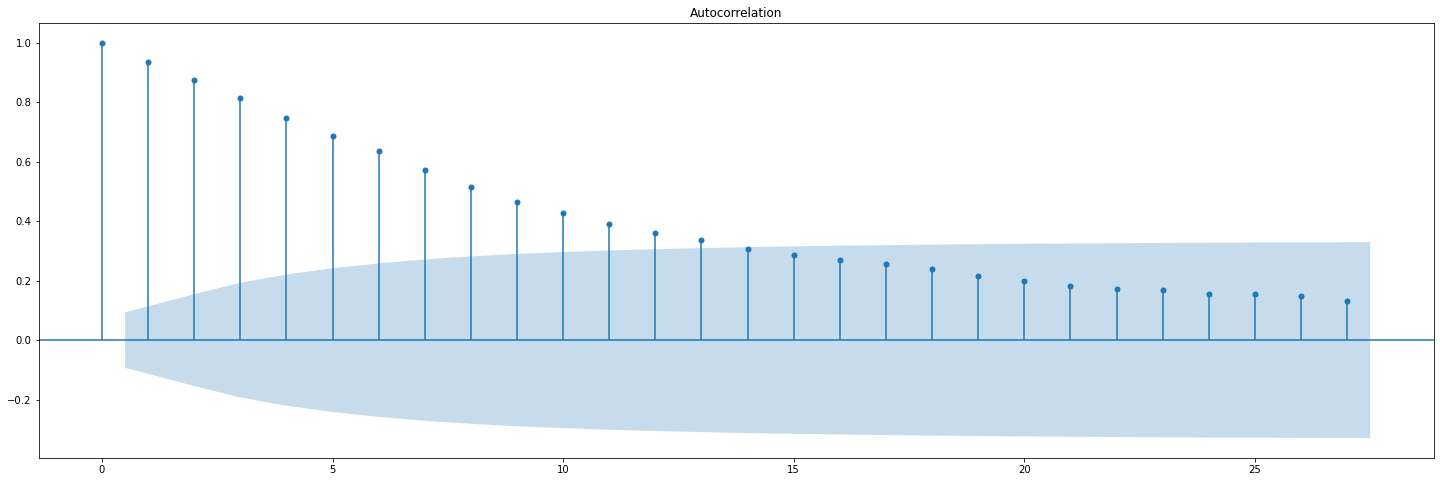

In [24]:
plot_acf(df_model);

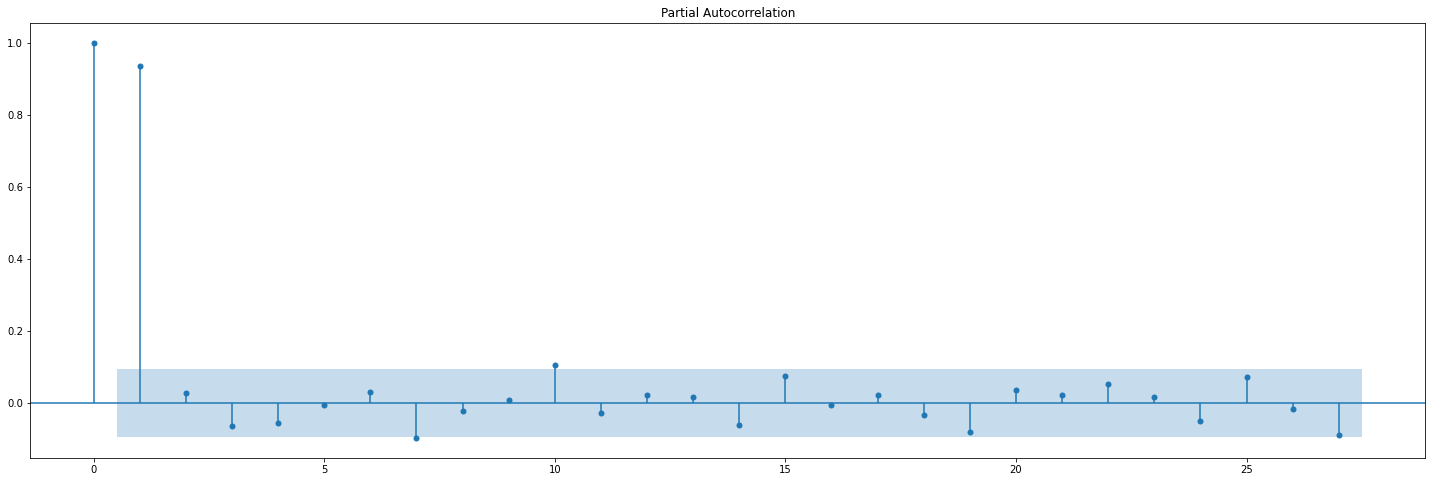

In [25]:
plot_pacf(df_model);

### ACF plot is clearly showing, time series observations are heavily impacted by past values. While PACF is showing limited number of spikes before cut-off

### Can select AR(1) and MA(0) process to build ARMA(1,0) model

### splittng time series into training and testing sets

In [26]:
train_end=datetime(2018,10,30)
test_end=datetime(2019,1,31)

In [27]:
train             = df_model[:train_end] 
test              = df_model[train_end + timedelta(days=1):test_end]

In [28]:
train.shape

(392, 1)

In [29]:
test.shape

(50, 1)

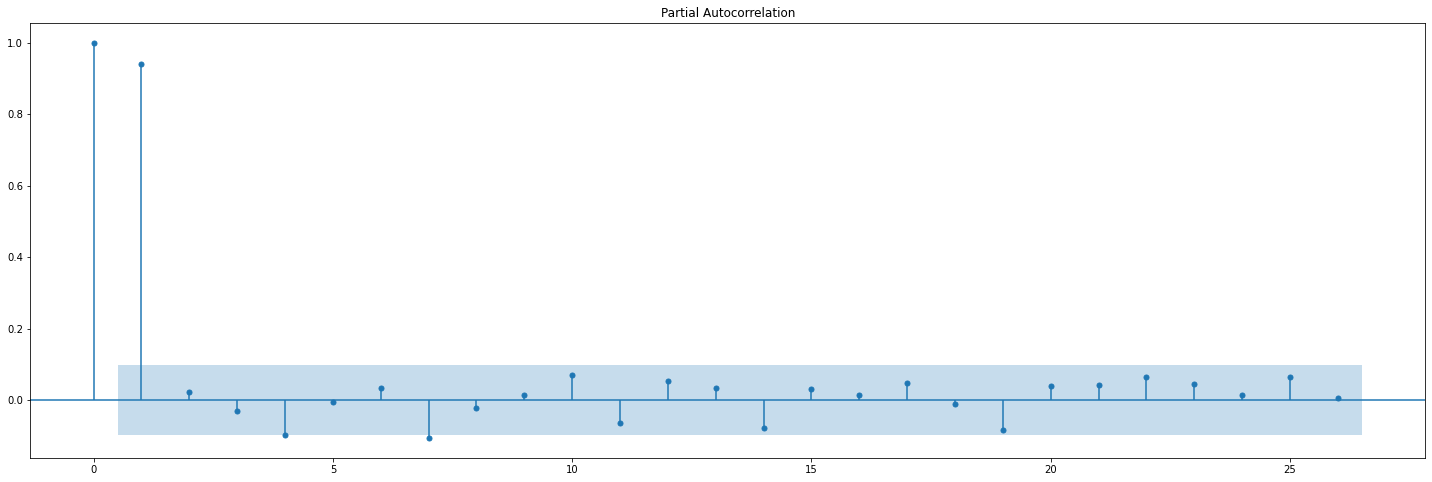

In [30]:
plot_pacf(train);

### building ARMA model

In [40]:
model=ARMA(train,(1,0))

In [41]:
model_fit=model.fit()

In [42]:
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  392
Model:                     ARMA(1, 0)   Log Likelihood                -812.829
Method:                       css-mle   S.D. of innovations              1.919
Date:                Thu, 22 Jul 2021   AIC                           1631.658
Time:                        14:39:23   BIC                           1643.572
Sample:                    05-01-2017   HQIC                          1636.380
                         - 10-30-2018                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          64.9812      1.524     42.646      0.000      61.995      67.968
ar.L1.Close     0.9387      0.017     55.553      0.000       0.906       0.972
                                    Roots       

### predicting forecasts using the model

In [43]:
forecast=model_fit.forecast(50)

In [56]:
forecast

(array([69.401379  , 69.13044889, 68.87612532, 68.63739039, 68.41328861,
        68.20292305, 68.00545174, 67.82008435, 67.64607896, 67.48273916,
        67.32941119, 67.18548139, 67.05037369, 66.92354737, 66.8044948 ,
        66.6927395 , 66.5878342 , 66.48935901, 66.39691982, 66.31014665,
        66.22869219, 66.15223045, 66.0804554 , 66.01307976, 65.94983388,
        65.89046463, 65.83473439, 65.78242011, 65.73331241, 65.68721474,
        65.64394261, 65.60332283, 65.56519281, 65.52939996, 65.49580101,
        65.46426149, 65.43465518, 65.40686357, 65.38077543, 65.35628635,
        65.33329832, 65.31171933, 65.29146302, 65.27244831, 65.25459909,
        65.23784393, 65.22211578, 65.20735167, 65.19349252, 65.18048287]),
 array([1.91916038, 2.6322374 , 3.12865814, 3.50834585, 3.81169568,
        4.06025698, 4.26729837, 4.44174513, 4.58997026, 4.71672242,
        4.82565378, 4.91964193, 5.00099748, 5.07160385, 5.13301503,
        5.18652596, 5.23322461, 5.27403126, 5.30972886, 5.340986

In [252]:
forecast[0]

array([69.401379  , 69.13044889, 68.87612532, 68.63739039, 68.41328861,
       68.20292305, 68.00545174, 67.82008435, 67.64607896, 67.48273916,
       67.32941119, 67.18548139, 67.05037369, 66.92354737, 66.8044948 ,
       66.6927395 , 66.5878342 , 66.48935901, 66.39691982, 66.31014665,
       66.22869219, 66.15223045, 66.0804554 , 66.01307976, 65.94983388,
       65.89046463, 65.83473439, 65.78242011, 65.73331241, 65.68721474,
       65.64394261, 65.60332283, 65.56519281, 65.52939996, 65.49580101,
       65.46426149, 65.43465518, 65.40686357, 65.38077543, 65.35628635,
       65.33329832, 65.31171933, 65.29146302, 65.27244831, 65.25459909,
       65.23784393, 65.22211578, 65.20735167, 65.19349252, 65.18048287])

In [46]:
pred_start=test.index[0]
pred_end=test.index[-1]

In [47]:
pred_start

Timestamp('2018-10-31 00:00:00')

In [48]:
predictions=model_fit.predict(start=pred_start, end=pred_end)

In [49]:
predictions

2018-10-31    69.401379
2018-11-01    69.130449
2018-11-02    68.876125
2018-11-05    68.637390
2018-11-06    68.413289
2018-11-07    68.202923
2018-11-08    68.005452
2018-11-09    67.820084
2018-11-12    67.646079
2018-11-13    67.482739
2018-11-14    67.329411
2018-11-15    67.185481
2018-11-16    67.050374
2018-11-19    66.923547
2018-11-20    66.804495
2018-11-21    66.692740
2018-11-22    66.587834
2018-11-23    66.489359
2018-11-26    66.396920
2018-11-27    66.310147
2018-11-28    66.228692
2018-11-29    66.152230
2018-11-30    66.080455
2018-12-03    66.013080
2018-12-04    65.949834
2018-12-05    65.890465
2018-12-06    65.834734
2018-12-07    65.782420
2018-12-10    65.733312
2018-12-11    65.687215
2018-12-12    65.643943
2018-12-13    65.603323
2018-12-14    65.565193
2018-12-17    65.529400
2018-12-18    65.495801
2018-12-19    65.464261
2018-12-20    65.434655
2018-12-21    65.406864
2018-12-24    65.380775
2018-12-25    65.356286
2018-12-26    65.333298
2018-12-27    65

### lets plot actual series and forecast

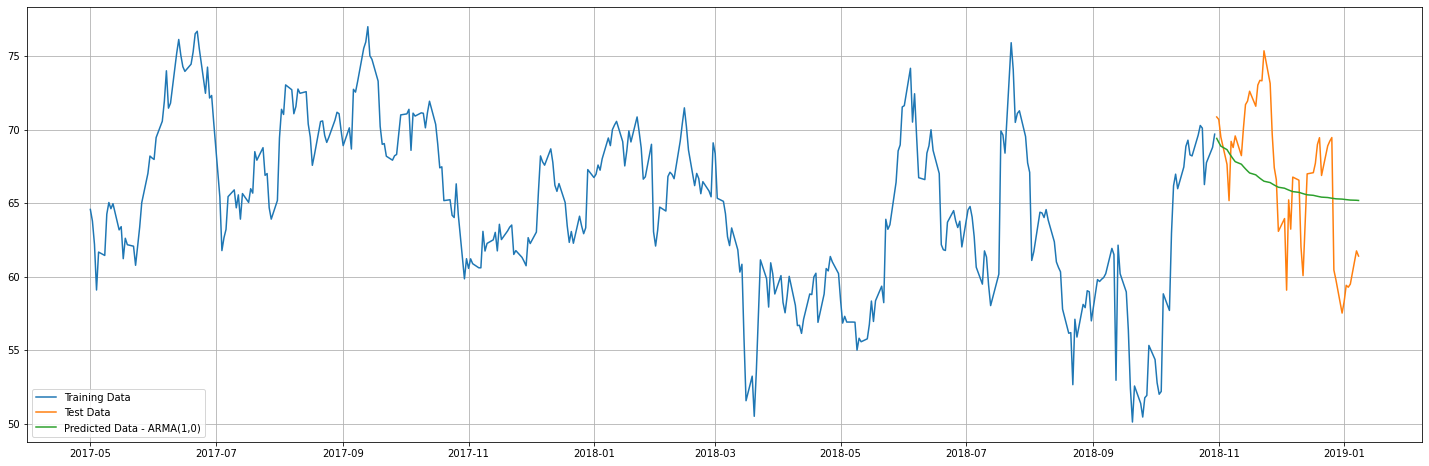

In [50]:
plt.plot(train,label='Training Data')
plt.plot(test,label='Test Data')
plt.plot(test.index,forecast[0],label='Predicted Data - ARMA(1,0)')
plt.legend(loc='best')
plt.grid();

### finding residuals

In [51]:
residuals = test['Close'].values - predictions.values

In [52]:
residuals 

array([ 1.458621  ,  1.55955111,  0.62387468, -0.99739039, -3.24328861,
        0.99707695,  0.77454826,  1.74991565,  0.58392104,  2.61726084,
        4.37058881,  4.75451861,  5.55962631,  4.66645263,  6.2255052 ,
        6.6572605 ,  6.7321658 ,  8.87064099,  6.74308018,  3.36985335,
        1.18130781,  0.43776955, -3.0004554 , -2.06307976, -6.86983388,
       -0.67046463, -2.60473439,  0.98757989,  0.82668759, -3.66721474,
       -5.57394261, -2.06332283,  1.42480719,  1.54060004,  2.21419899,
        3.52573851,  4.01534482,  1.47313643,  3.50922457,  3.85371365,
        4.12670168, -4.86171933, -5.51146302, -7.75244831, -6.95459909,
       -5.82784393, -5.94211578, -5.71735167, -3.44349252, -3.78048287])

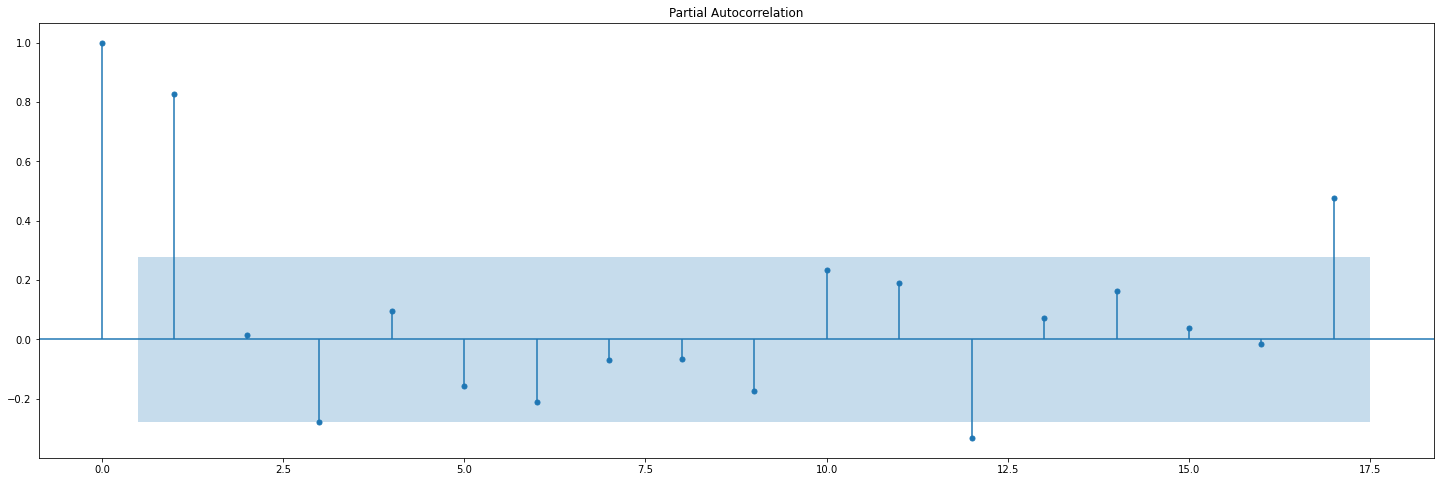

In [53]:
plot_pacf(residuals);

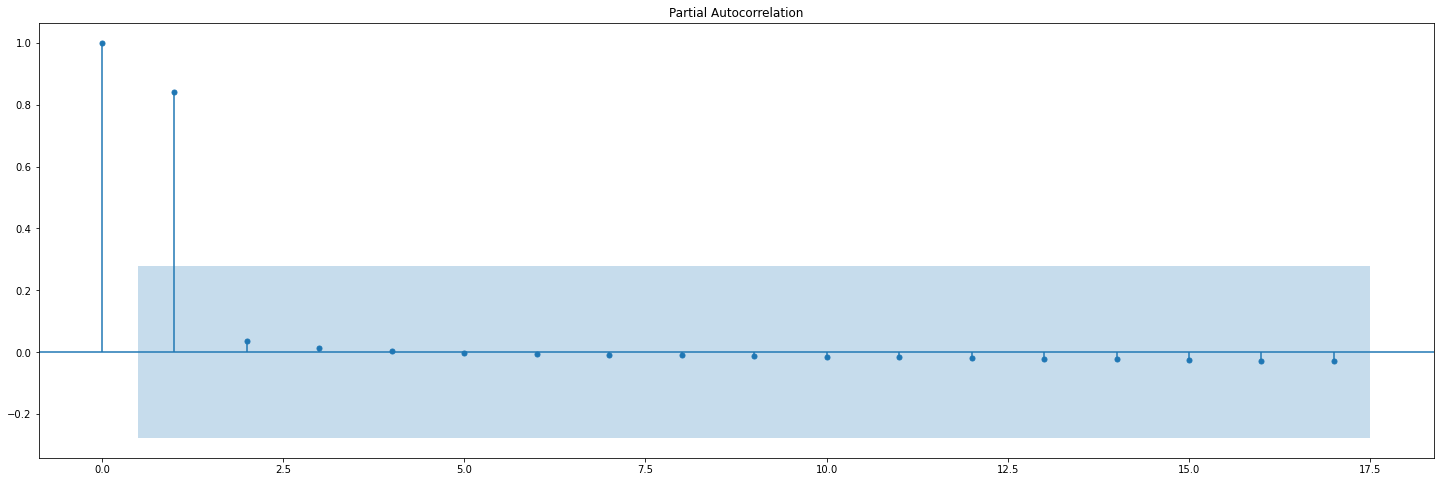

In [55]:
plot_pacf(forecast[1]);

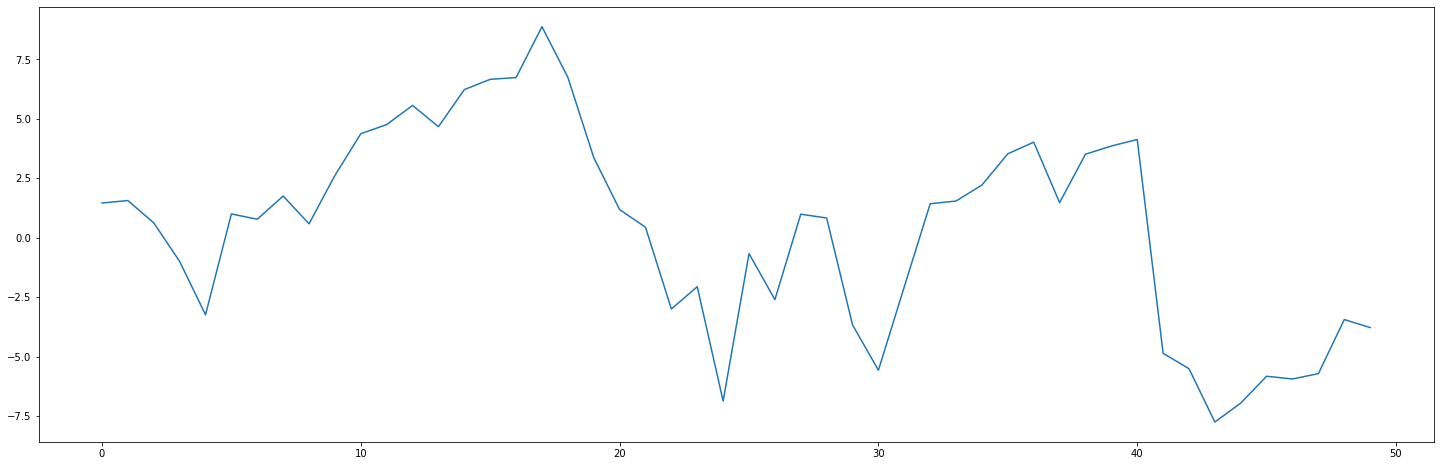

In [57]:
plt.plot(residuals)
plt.show()

### residual q-q plot for to check model performance 

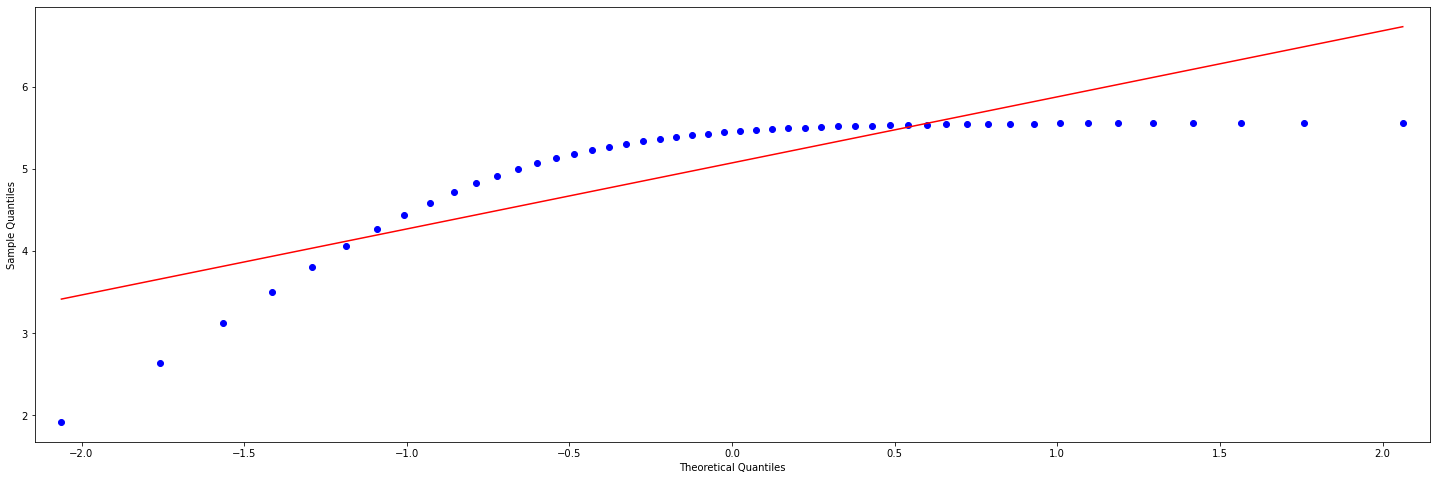

In [61]:
qqplot(forecast[1],line="s");

### accuracy matrix

In [62]:
from sklearn.metrics import mean_squared_error

In [63]:
mean_squared_error(test.values,predictions.values,squared=False)

4.197946509245838

In [64]:
def MAPE(y_true, y_pred):
    return np.mean((np.abs(y_true-y_pred))/(y_true))*100

In [267]:
test['Close'].values

array([70.86, 70.69, 69.5 , 67.64, 65.17, 69.2 , 68.78, 69.57, 68.23,
       70.1 , 71.7 , 71.94, 72.61, 71.59, 73.03, 73.35, 73.32, 75.36,
       73.14, 69.68, 67.41, 66.59, 63.08, 63.95, 59.08, 65.22, 63.23,
       66.77, 66.56, 62.02, 60.07, 63.54, 66.99, 67.07, 67.71, 68.99,
       69.45, 66.88, 68.89, 69.21, 69.46, 60.45, 59.78, 57.52, 58.3 ,
       59.41, 59.28, 59.49, 61.75, 61.4 ])

In [268]:
forecast[0]

array([69.401379  , 69.13044889, 68.87612532, 68.63739039, 68.41328861,
       68.20292305, 68.00545174, 67.82008435, 67.64607896, 67.48273916,
       67.32941119, 67.18548139, 67.05037369, 66.92354737, 66.8044948 ,
       66.6927395 , 66.5878342 , 66.48935901, 66.39691982, 66.31014665,
       66.22869219, 66.15223045, 66.0804554 , 66.01307976, 65.94983388,
       65.89046463, 65.83473439, 65.78242011, 65.73331241, 65.68721474,
       65.64394261, 65.60332283, 65.56519281, 65.52939996, 65.49580101,
       65.46426149, 65.43465518, 65.40686357, 65.38077543, 65.35628635,
       65.33329832, 65.31171933, 65.29146302, 65.27244831, 65.25459909,
       65.23784393, 65.22211578, 65.20735167, 65.19349252, 65.18048287])

In [65]:
MAPE(test['Close'].values,forecast[0])

5.406823050484394

## forecast

In [66]:
model=ARMA(df_model,(1,0))

In [67]:
model_fit=model.fit()

In [68]:
forecast=model_fit.forecast(15)[0]

In [69]:
forecast

array([61.63642445, 61.85690831, 62.06252637, 62.25428091, 62.43310669,
       62.59987538, 62.75539994, 62.90043848, 63.03569799, 63.16183783,
       63.27947287, 63.38917653, 63.49148358, 63.58689272, 63.67586904])

In [70]:
forecasting=pd.DataFrame(forecast)

In [71]:
forecasting

,0
0,61.636424
1,61.856908
2,62.062526
3,62.254281
4,62.433107
5,62.599875
6,62.755400
7,62.900438
8,63.035698
9,63.161838


In [72]:
date = pd.date_range(start='01/09/2019', periods=15, freq=BDay())
forecasting['timestamp']=date
forecasting=forecasting.set_index('timestamp')
forecasting

,0
timestamp,
2019-01-09,61.636424
2019-01-10,61.856908
2019-01-11,62.062526
2019-01-14,62.254281
2019-01-15,62.433107
2019-01-16,62.599875
2019-01-17,62.755400
2019-01-18,62.900438
2019-01-21,63.035698


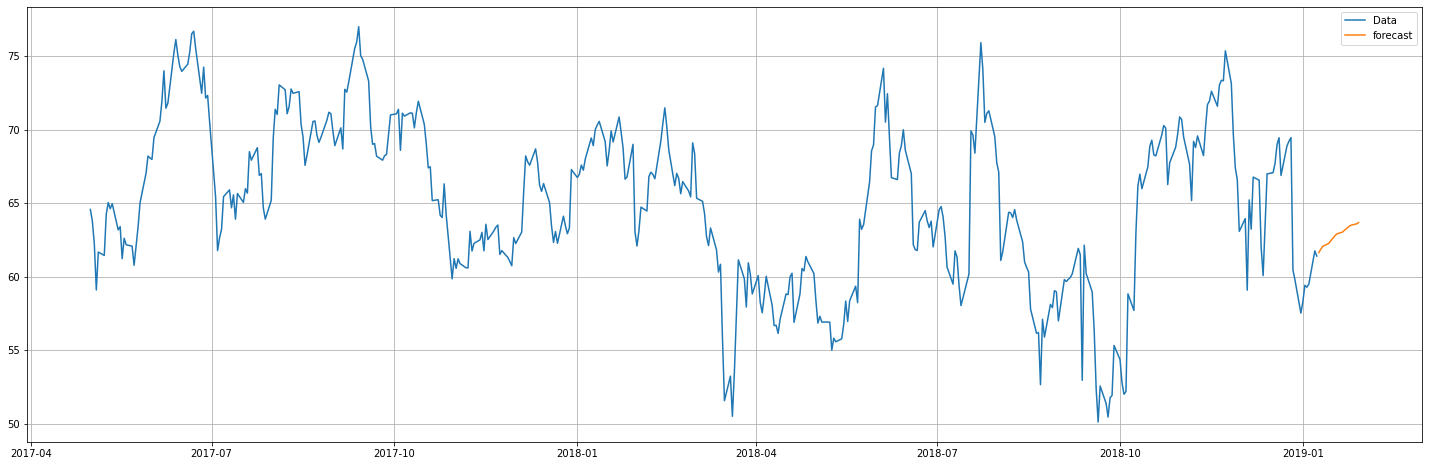

In [73]:
plt.plot(df_model,label='Data')
plt.plot(forecasting,label='forecast')
plt.legend(loc='best')
plt.grid();

# End